In [265]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
from collections import deque

In [267]:
num_nodes = 10000
k_avg = 20

nodes_positions = np.random.rand(num_nodes, 2)
radius = np.sqrt(k_avg / (np.pi * num_nodes))

rgg = nx.random_geometric_graph(num_nodes, radius, pos={i: nodes_positions[i] for i in range(num_nodes)})

In [268]:
class Infectious_Network():
    def __init__(self, network: nx.Graph, infection_probi: float, recovery_probi: float, initial_infection: float, 
                 concentrated: bool):
        self.network = network
        self.initial_infection = initial_infection
        self.concentrated = concentrated

        self.num_nodes = network.number_of_nodes()
        self.positions = nx.get_node_attributes(network, "pos")

        self.state = np.zeros(self.num_nodes) # S = 0, I = 1, R = 2
        self.infection_probi = infection_probi
        self.recovery_probi = recovery_probi 

        if concentrated:
            self.concentrated_infection()
        else:
            self.disperse_infection()

    def disperse_infection(self): # randomly choose nodes to infect
        initial_infected_nodes = np.random.choice(self.num_nodes, 
                                                  int(self.initial_infection*self.num_nodes), replace=False)
        for i in initial_infected_nodes:
            self.state[i] = 1  

    def concentrated_infection(self): # choose nodes closest to the outbreak location
        outbreak_location = np.random.rand(1, 2)
        nodes_positions = np.array(list(self.positions.values()))
        nodes_distances_from_outbreak = np.linalg.norm(nodes_positions - outbreak_location, axis=1)
        nodes_sorted_by_distance = np.argsort(nodes_distances_from_outbreak)
        initial_infected_nodes = nodes_sorted_by_distance[:int(self.initial_infection*self.num_nodes)]
        
        for i in initial_infected_nodes:
            self.state[i] = 1     

    def increment_time(self):
        new_state = self.state.copy()
        for i in range(self.num_nodes):
            if self.state[i] == 1: # I = 1
                # check if node i's neighours could be infected
                for j in self.network.neighbors(i):
                    if self.state[j] == 0 and np.random.rand() < self.infection_probi: # S = 0
                        new_state[j] = 1
                # check if node i could recover
                if np.random.rand() < self.recovery_probi:
                    new_state[i] = 2
        self.state = new_state


    def increment_till_extinction(self):
        S, I, R = [], [], []
        while len([i for i in self.state if i == 1]):
            S.append(len([i for i in self.state if i == 0]))
            I.append(len([i for i in self.state if i == 1]))
            R.append(len([i for i in self.state if i == 2]))

            self.increment_time()
        return S, I, R

In [270]:
def find_basic_reproduction_number(infection_probi, recovery_probi):
    return infection_probi * k_avg / recovery_probi

In [325]:
initial_infection = 0.001
infection_probability = 0.3
infection_probability_small = 0.01
infection_probability_mid = 0.025
recovery_probability = 0.1
sample_size = 50
max_size = 1000

Location and value of peak against time

In [379]:
basic_reproduction_number_array = np.arange(0.5, 6, 0.2)
sample_size = 100
alpha = 0.3

In [ ]:

infection_peak_val_c = np.zeros((sample_size, len(basic_reproduction_number_array)))
infection_peak_time_c = np.zeros((sample_size, len(basic_reproduction_number_array)))

infection_peak_val_d = np.zeros((sample_size, len(basic_reproduction_number_array)))
infection_peak_time_d = np.zeros((sample_size, len(basic_reproduction_number_array)))

outbreak_size_c = np.zeros((sample_size, len(basic_reproduction_number_array)))
outbreak_extinction_time_c = np.zeros((sample_size, len(basic_reproduction_number_array)))

outbreak_size_d = np.zeros((sample_size, len(basic_reproduction_number_array)))
outbreak_extinction_time_d = np.zeros((sample_size, len(basic_reproduction_number_array)))

In [ ]:
for sample_num in range(sample_size):
    for concentrated in [False, True]:
        for r_num, basic_reproduction_number in enumerate(basic_reproduction_number_array):
            print(sample_num, basic_reproduction_number)
            infection_probability_brn = basic_reproduction_number * recovery_probability / k_avg
            rgg = nx.random_geometric_graph(num_nodes, radius, pos={i: nodes_positions[i] for i in range(num_nodes)})
            infectious_rgg = Infectious_Network(rgg, infection_probability_brn, recovery_probability, initial_infection, concentrated)
            S, I, R = infectious_rgg.increment_till_extinction()
            if concentrated:
                infection_peak_val_c[sample_num][r_num] = np.max(I)
                infection_peak_time_c[sample_num][r_num] = np.argmax(I)
                outbreak_size_c[sample_num][r_num] = R[-1]
                outbreak_extinction_time_c[sample_num][r_num] = len(R)
            else: 
                infection_peak_val_d[sample_num][r_num] = np.max(I)
                infection_peak_time_d[sample_num][r_num] = np.argmax(I)
                outbreak_size_d[sample_num][r_num] = R[-1]
                outbreak_extinction_time_d[sample_num][r_num] = len(R)

In [312]:
average_infection_peak_val_c = np.mean(infection_peak_val_c, axis=0)
average_infection_peak_time_c = np.mean(infection_peak_time_c, axis=0)

average_infection_peak_val_d = np.mean(infection_peak_val_d, axis=0)
average_infection_peak_time_d = np.mean(infection_peak_time_d, axis=0)

average_outbreak_size_c = np.mean(outbreak_size_c, axis=0)
average_outbreak_size_d = np.mean(outbreak_size_d, axis=0)

var_outbreak_size_c = np.var(outbreak_size_c, axis=0)
var_outbreak_size_d = np.var(outbreak_size_d, axis=0)

average_outbreak_extinction_time_c = np.mean(outbreak_extinction_time_c, axis=0)
average_outbreak_extinction_time_d = np.mean(outbreak_extinction_time_d, axis=0)

var_outbreak_extinction_time_c = np.var(outbreak_extinction_time_c, axis=0)
var_outbreak_extinction_time_d = np.var(outbreak_extinction_time_d, axis=0)

In [ ]:
for sample_num in range(sample_size):
    plt.scatter(basic_reproduction_number_array, average_infection_peak_val_c[sample_num], lw = 0, alpha = alpha, color="#1f77b4")
plt.plot(basic_reproduction_number_array, average_infection_peak_val_c, label="concentrated infection")

for sample_num in range(sample_size):
    plt.scatter(basic_reproduction_number_array, average_infection_peak_val_d[sample_num], lw = 0, alpha = alpha, color="#ff7f0e")
plt.plot(basic_reproduction_number_array, average_infection_peak_val_d, label="dispersed infection")

plt.legend()
plt.title(f"Infection peak value in a random geometric network, sample size = {sample_size}")
plt.xlabel("basic reproduction number")
plt.ylabel("infection peak value")
plt.show()

In [ ]:
for sample_num in range(sample_size):
    plt.scatter(basic_reproduction_number_array, average_infection_peak_time_c[sample_num], lw = 0, alpha = alpha, color="#1f77b4")
plt.plot(basic_reproduction_number_array, average_infection_peak_time_c, label="concentrated infection")

for sample_num in range(sample_size):
    plt.scatter(basic_reproduction_number_array, average_infection_peak_time_d[sample_num], lw = 0, alpha = alpha, color="#ff7f0e")
plt.plot(basic_reproduction_number_array, average_infection_peak_time_d, label="dispersed infection")

plt.legend()
plt.title(f"Infection peak time in a random geometric network, sample size = {sample_size}")
plt.xlabel("basic reproduction number")
plt.ylabel("infection peak time")
plt.show()

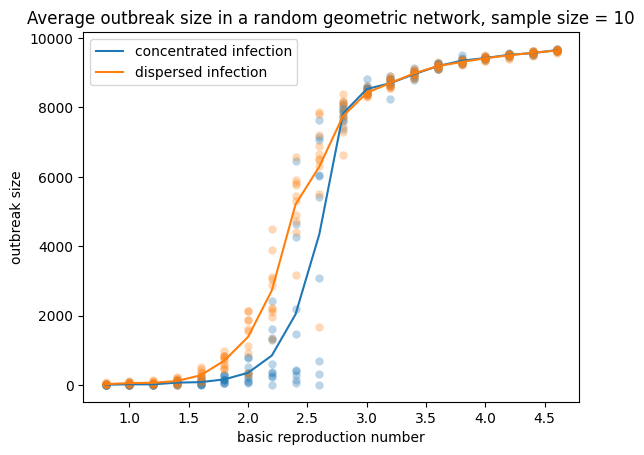

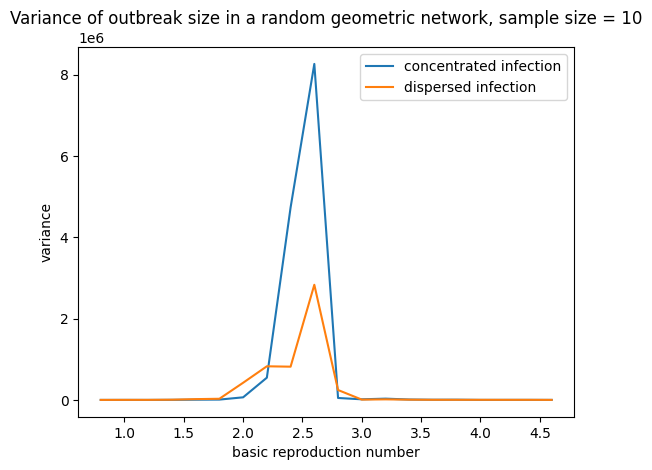

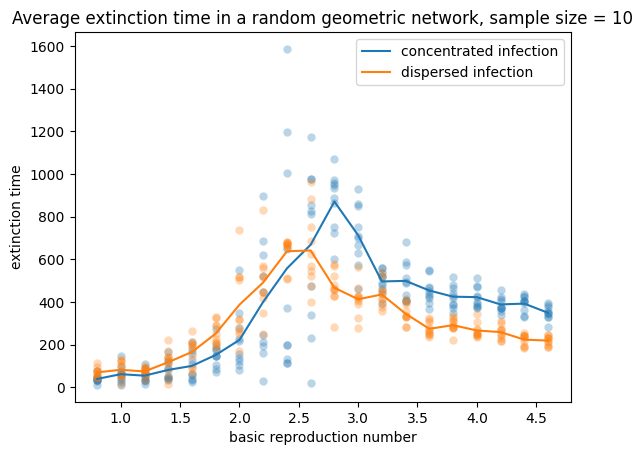

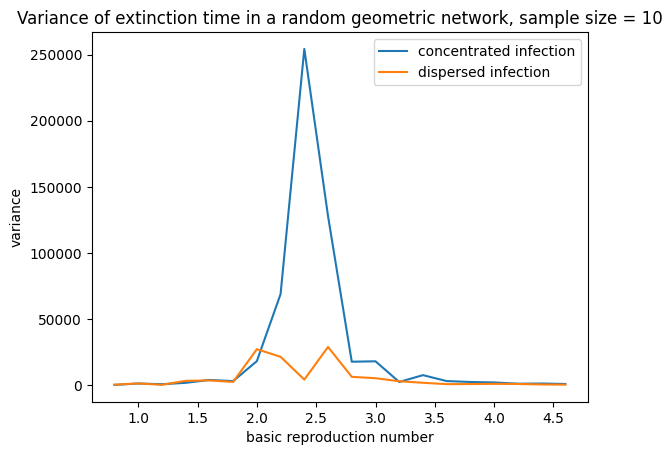

In [317]:
for sample_num in range(sample_size):
    plt.scatter(basic_reproduction_number_array, outbreak_size_c[sample_num], lw = 0, alpha = alpha, color="#1f77b4")
plt.plot(basic_reproduction_number_array, average_outbreak_size_c, label="concentrated infection", color="#1f77b4")

for sample_num in range(sample_size):
    plt.scatter(basic_reproduction_number_array, outbreak_size_d[sample_num], lw = 0, alpha = alpha, color="#ff7f0e")
plt.plot(basic_reproduction_number_array, average_outbreak_size_d, label="dispersed infection", color="#ff7f0e")
plt.legend()
plt.title(f"Average outbreak size in a random geometric network, sample size = {sample_size}")
plt.xlabel("basic reproduction number")
plt.ylabel("outbreak size")
plt.show()

plt.plot(basic_reproduction_number_array, var_outbreak_size_c, label="concentrated infection")
plt.plot(basic_reproduction_number_array, var_outbreak_size_d, label="dispersed infection")
plt.legend()
plt.title(f"Variance of outbreak size in a random geometric network, sample size = {sample_size}")
plt.xlabel("basic reproduction number")
plt.ylabel("variance")
plt.show()

In [ ]:
for sample_num in range(sample_size):
    plt.scatter(basic_reproduction_number_array, outbreak_extinction_time_c[sample_num], lw = 0, alpha = alpha, color="#1f77b4")
plt.plot(basic_reproduction_number_array, average_outbreak_extinction_time_c, label="concentrated infection")

for sample_num in range(sample_size):
    plt.scatter(basic_reproduction_number_array, outbreak_extinction_time_d[sample_num], lw = 0, alpha = alpha, color="#ff7f0e")
plt.plot(basic_reproduction_number_array, average_outbreak_extinction_time_d, label="dispersed infection")
plt.legend()
plt.title(f"Average extinction time in a random geometric network, sample size = {sample_size}")
plt.xlabel("basic reproduction number")
plt.ylabel("extinction time")
plt.show()

plt.plot(basic_reproduction_number_array, var_outbreak_extinction_time_c, label="concentrated infection")
plt.plot(basic_reproduction_number_array, var_outbreak_extinction_time_d, label="dispersed infection")
plt.legend()
plt.title(f"Variance of extinction time in a random geometric network, sample size = {sample_size}")
plt.xlabel("basic reproduction number")
plt.ylabel("variance")
plt.show()